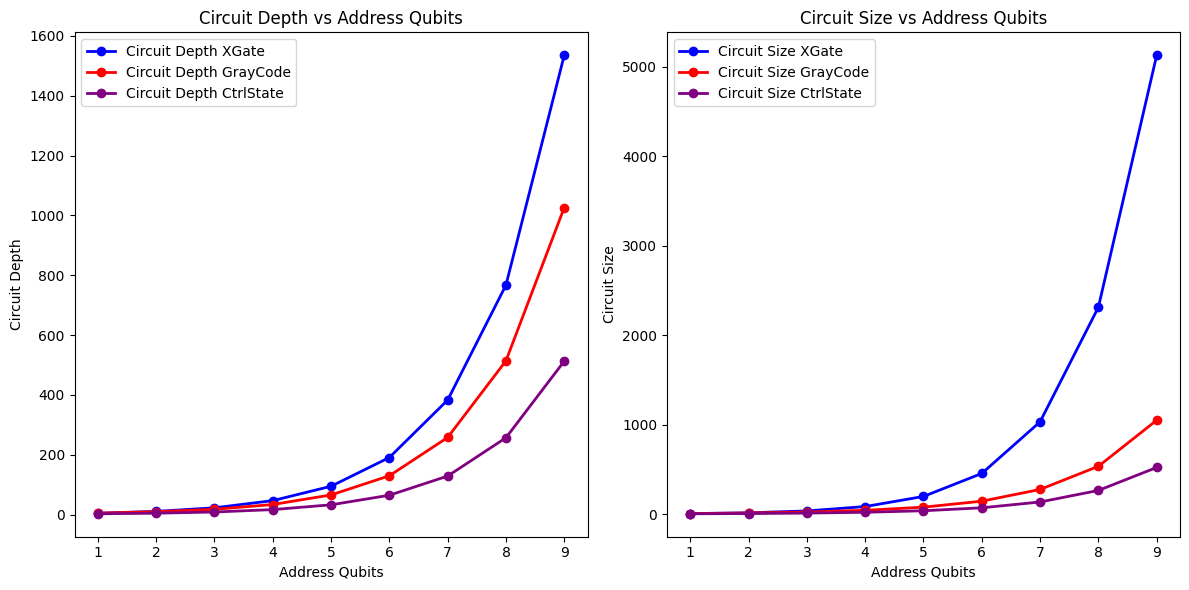

In [2]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import HGate, CXGate, RYGate, XGate
from numpy import arcsin, sqrt, pi
import math
from matplotlib import pyplot as plt
# Funzione per calcolare il valore di θ
def calculate_theta(value, max_value):
    X_N = value / sqrt(max_value)
    return 2 * arcsin(X_N)


# Funzione per generare il codice Gray
def gray_code(n):
    """Generate n-bit Gray code iteratively."""
    if n == 0:
        return ['0']
    if n == 1:
        return ['0', '1']
    
    gray_codes = ['0', '1']
    for i in range(2, n + 1):
        # Create the next sequence by reflecting the current sequence
        reflected = ['1' + code for code in reversed(gray_codes)]
        gray_codes = ['0' + code for code in gray_codes] + reflected
    
    return gray_codes

# Funzione per calcolare la profondità e la dimensione del circuito per diverse dimensioni del dataset
def calculate_circuit_metrics_XGate(memory_values):
    max_value = sum([x**2 for x in memory_values])
    thetas = [calculate_theta(value, max_value) for value in memory_values]
    N = len(memory_values)
    n = int(math.log2(N))
    
    qaddr = QuantumRegister(n, 'addr')
    qdata = QuantumRegister(1, 'data')
    circuit = QuantumCircuit(qaddr, qdata)
    
    for qa in qaddr:
        circuit.append(HGate(), [qa])
    circuit.barrier()
    
    for i, el in enumerate(memory_values):
        theta = calculate_theta(el, max_value)
        binary_index = bin(i)[2:].zfill(n)
    
        for j, bit in enumerate(binary_index):
            if bit == '0':
                circuit.append(XGate(), [qaddr[j]])
    
        CRYGate = RYGate(theta).control(n)
        circuit.append(CRYGate, qaddr[:n] + [qdata[0]])
    
        for j, bit in enumerate(binary_index):
            if bit == '0':
                circuit.append(XGate(), [qaddr[j]])
    
        circuit.barrier()


    return circuit.depth(), circuit.size()

def calculate_circuit_metrics_GrayCode(memory_values):
    max_value = sum([x**2 for x in memory_values])
    thetas = [calculate_theta(value, max_value) for value in memory_values]
    N = len(memory_values)
    n = int(math.log2(N))
    
    qaddr = QuantumRegister(n, 'addr')
    previous_bit = [1] * n
    qdata = QuantumRegister(1, 'data')
    circuit = QuantumCircuit(qaddr, qdata)
    
    for qa in qaddr:
        circuit.append(HGate(), [qa])
    circuit.barrier()
    
    gray_codes = gray_code(n)
    binary_index = list(enumerate(gray_codes[0]))
    
    for i, el in enumerate(memory_values):
        theta = calculate_theta(el, max_value)
        for j, bit in binary_index:
            if bit == '0' and previous_bit[j] == 1:
                circuit.append(XGate(), [qaddr[j]])
            previous_bit[j] = int(bit)
        
        CRYGate = RYGate(theta).control(n)
        circuit.append(CRYGate, qaddr[:n] + [qdata[0]])
        
        if i < N - 1:
            binary_index = list(enumerate(gray_codes[i + 1]))
            for j, next_bit in binary_index:
                if next_bit == '1' and previous_bit[j] == 0:
                    circuit.append(XGate(), [qaddr[j]])
        else:
            for j, bit in binary_index:
                if bit == '0':
                    circuit.append(XGate(), [qaddr[j]])
        
        circuit.barrier()

    return circuit.depth(), circuit.size()

def calculate_circuit_metrics(memory_values):
    max_value = sum([x**2 for x in memory_values])
    thetas = [calculate_theta(value, max_value) for value in memory_values]
    N = len(memory_values)
    n = int(math.log2(N))
    
    qaddr = QuantumRegister(n, 'addr')
    qdata = QuantumRegister(1, 'data')
    circuit = QuantumCircuit(qaddr, qdata)
    
    for qa in qaddr:
        circuit.append(HGate(), [qa])
    circuit.barrier()
    
    i=0
    for el in memory_values:
        theta=calculate_theta(el, max_value)
        binary_index = bin(i)[2:].zfill(n)
        CRYGate = RYGate(theta).control(n, ctrl_state=binary_index)
        circuit.append(CRYGate, qaddr[:] + [qdata[0]])
        i+=1
        circuit.barrier()


    return circuit.depth(), circuit.size()

# Generare dataset di diverse dimensioni (potenze di 2)
dataset_sizes = [i for i in range(1, 10)]
depths_XGate = []
sizes_XGate = []
depths_GrayCode = []
sizes_GrayCode = []
depths_ctrlstate = []
sizes_ctrlstate = []

for size in dataset_sizes:
    memory_values = list(range(1, (2**size) + 1))
    depth, size = calculate_circuit_metrics_XGate(memory_values)
    depths_XGate.append(depth)
    sizes_XGate.append(size)
    depth, size = calculate_circuit_metrics_GrayCode(memory_values)
    depths_GrayCode.append(depth)
    sizes_GrayCode.append(size)
    depth, size = calculate_circuit_metrics(memory_values)
    depths_ctrlstate.append(depth)
    sizes_ctrlstate.append(size)


# Plotting
plt.figure(figsize=(12, 6))

# Tracciare Circuit Depth
plt.subplot(1, 2, 1)
plt.plot(dataset_sizes, depths_XGate, marker='o', color='blue', linewidth=2, label='Circuit Depth XGate')
plt.plot(dataset_sizes, depths_GrayCode, marker='o', color='red', linewidth=2, label='Circuit Depth GrayCode')
plt.plot(dataset_sizes, depths_ctrlstate, marker='o', color='purple', linewidth=2, label='Circuit Depth CtrlState')
plt.xlabel('Address Qubits')
plt.ylabel('Circuit Depth')
plt.legend()
plt.title('Circuit Depth vs Address Qubits')

# Tracciare Circuit Size
plt.subplot(1, 2, 2)
plt.plot(dataset_sizes, sizes_XGate, marker='o', color='blue', linewidth=2, label='Circuit Size XGate')
plt.plot(dataset_sizes, sizes_GrayCode, marker='o', color='red', linewidth=2, label='Circuit Size GrayCode')
plt.plot(dataset_sizes, sizes_ctrlstate, marker='o', color='purple', linewidth=2, label='Circuit Size CtrlState')
plt.xlabel('Address Qubits')
plt.ylabel('Circuit Size')
plt.legend()
plt.title('Circuit Size vs Address Qubits')

plt.tight_layout()
plt.show()





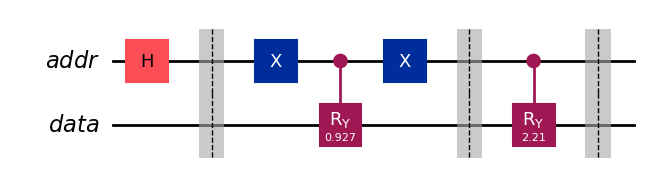

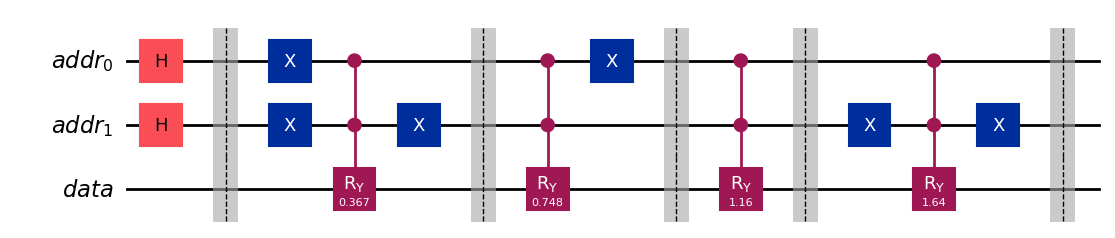

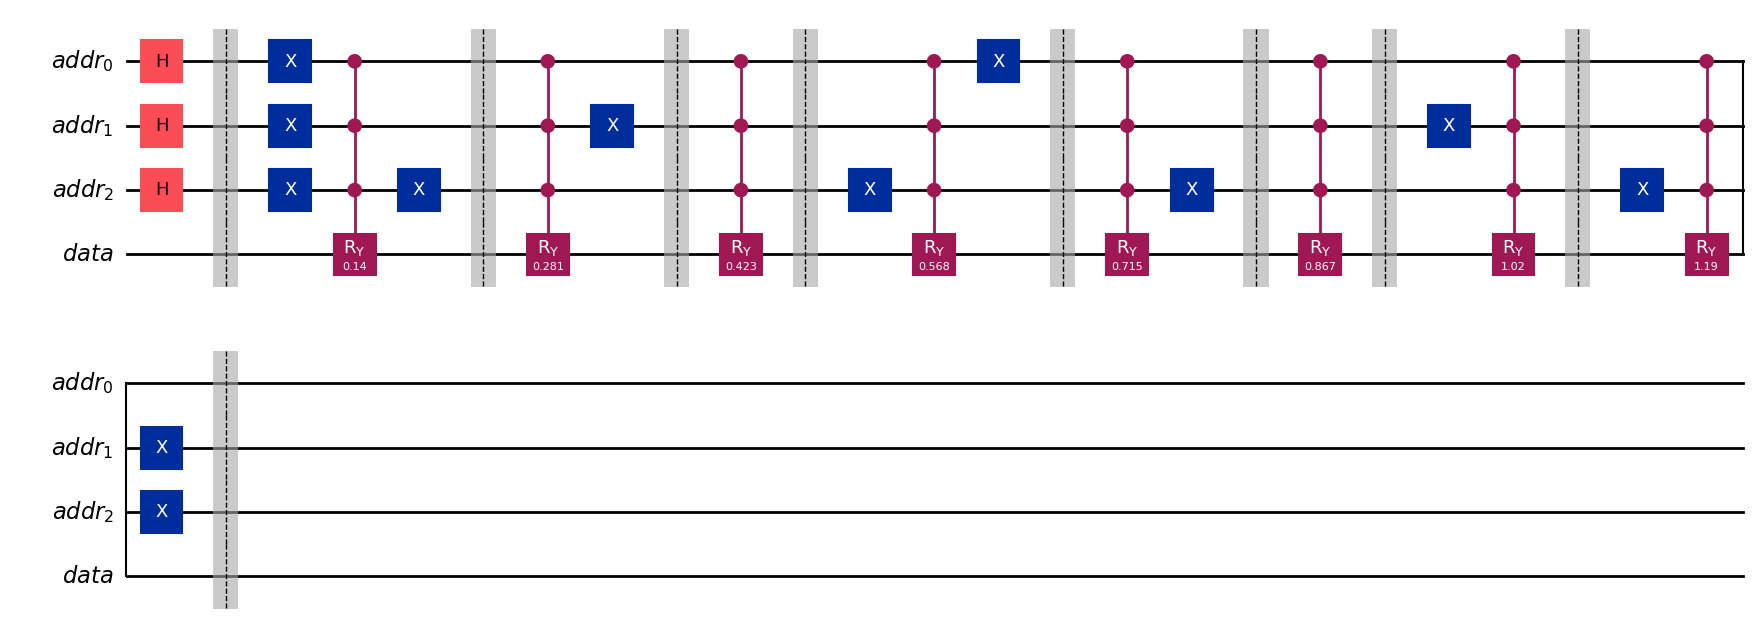

In [8]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import HGate, CXGate, RYGate, XGate
from numpy import arcsin, sqrt, pi
import math
from matplotlib import pyplot as plt
from IPython.display import display
# Funzione per calcolare il valore di θ
def calculate_theta(value, max_value):
    X_N = value / sqrt(max_value)
    return 2 * arcsin(X_N)


# Funzione per generare il codice Gray
def gray_code(n):
    """Generate n-bit Gray code iteratively."""
    if n == 0:
        return ['0']
    if n == 1:
        return ['0', '1']
    
    gray_codes = ['0', '1']
    for i in range(2, n + 1):
        # Create the next sequence by reflecting the current sequence
        reflected = ['1' + code for code in reversed(gray_codes)]
        gray_codes = ['0' + code for code in gray_codes] + reflected
    
    return gray_codes


def calculate_circuit_metrics_GrayCode(memory_values):
    max_value = sum([x**2 for x in memory_values])
    thetas = [calculate_theta(value, max_value) for value in memory_values]
    N = len(memory_values)
    n = int(math.log2(N))
    countXGate = 0

    qaddr = QuantumRegister(n, 'addr')
    previous_bit = [1] * n
    qdata = QuantumRegister(1, 'data')
    circuit = QuantumCircuit(qaddr, qdata)
    
    for qa in qaddr:
        circuit.append(HGate(), [qa])
    circuit.barrier()
    
    gray_codes = gray_code(n)
    binary_index = list(enumerate(gray_codes[0]))
    
    for i, el in enumerate(memory_values):
        theta = calculate_theta(el, max_value)
        for j, bit in binary_index:
            if bit == '0' and previous_bit[j] == 1:
                circuit.append(XGate(), [qaddr[j]])
                countXGate+=1
            previous_bit[j] = int(bit)
        
        CRYGate = RYGate(theta).control(n)
        circuit.append(CRYGate, qaddr[:n] + [qdata[0]])
        
        if i < N - 1:
            binary_index = list(enumerate(gray_codes[i + 1]))
            for j, next_bit in binary_index:
                if next_bit == '1' and previous_bit[j] == 0:
                    circuit.append(XGate(), [qaddr[j]])
                    countXGate+=1
        else:
            for j, bit in binary_index:
                if bit == '0':
                    circuit.append(XGate(), [qaddr[j]])
                    countXGate+=1
        
        circuit.barrier()

    # Draw the circuit and display the number of X gates
    display(circuit.draw(output='mpl'))


dataset_size = {i for i in range(1, 4)}

for size in dataset_size:
    memory_values = [i for i in range(1, (2**size) + 1)]

    calculate_circuit_metrics_GrayCode(memory_values)


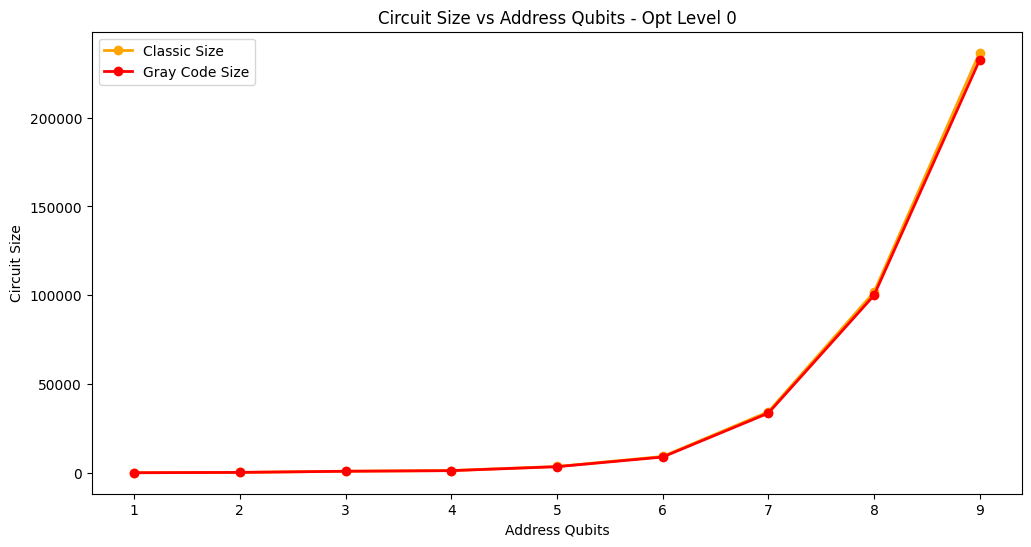

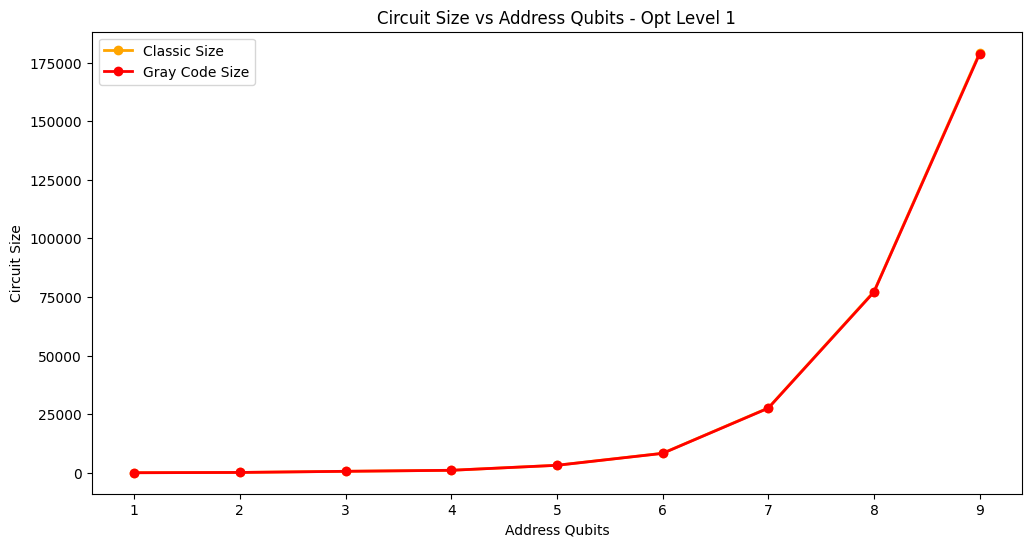

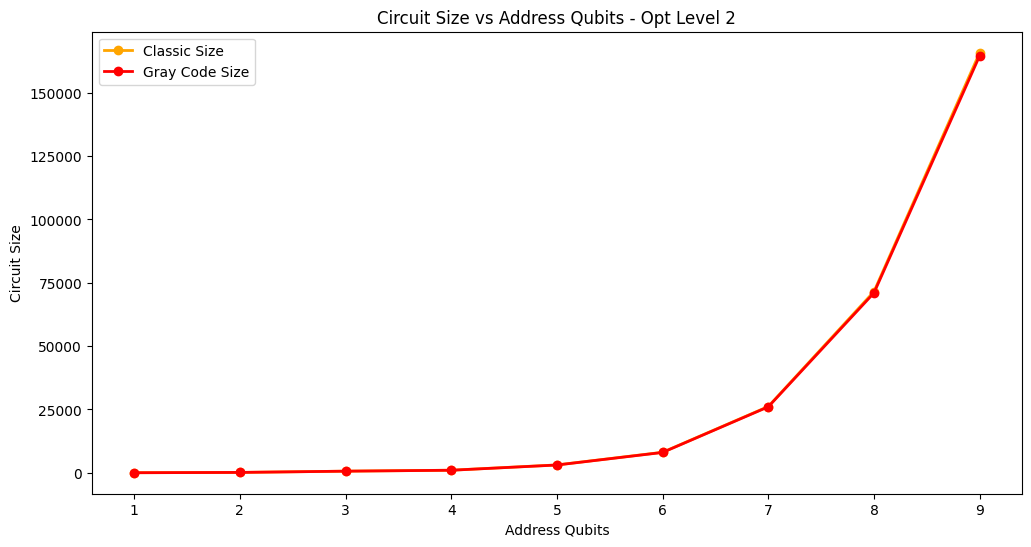

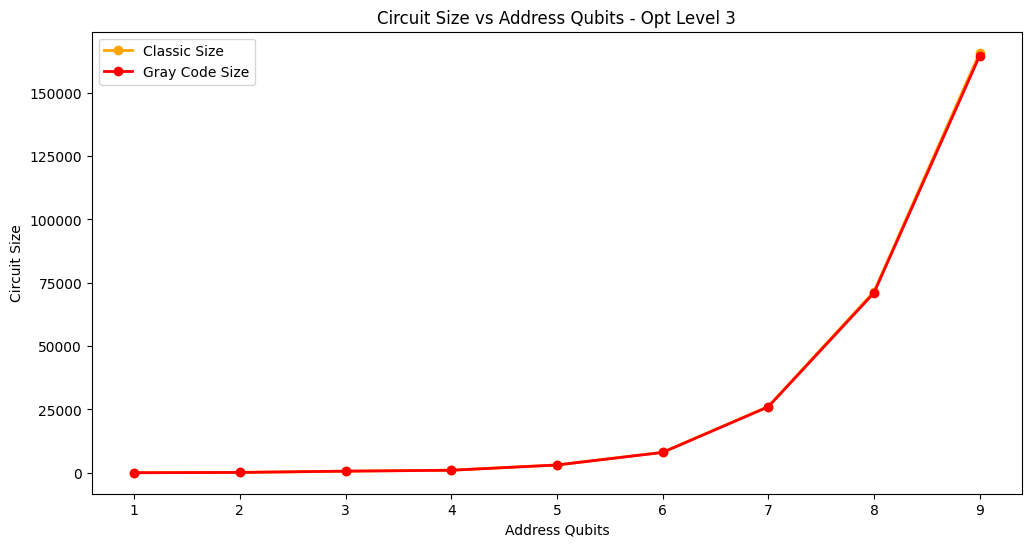

In [2]:
from lib.circuit_metrics import ffqram_metrics_graycode, ffqram_metrics_classic
from matplotlib import pyplot as plt

size = range(1,10)

classic_opt_size = []
gray_opt_size = []


for i in range(0,4):
    for el in size:
        _, _ , _ , classic_size , _ , _ = ffqram_metrics_classic(el, barrier=False, opt_lvl=i)
        _, _ , _ , gray_size , _ , _ = ffqram_metrics_graycode(el, barrier=False, opt_lvl=i)

        classic_opt_size.append(classic_size)
        gray_opt_size.append(gray_size)

    plt.figure(figsize=(12, 6))
    plt.xlabel('Address Qubits')
    plt.ylabel('Circuit Size')
    plt.title(f'Circuit Size vs Address Qubits - Opt Level {i}')
    plt.plot(size, classic_opt_size, marker='o', color='orange', linewidth=2, label='Classic Size')
    plt.plot(size, gray_opt_size, marker='o', color='red', linewidth=2, label='Gray Code Size')
    plt.legend()
    plt.show()
    classic_opt_size = []
    gray_opt_size = []

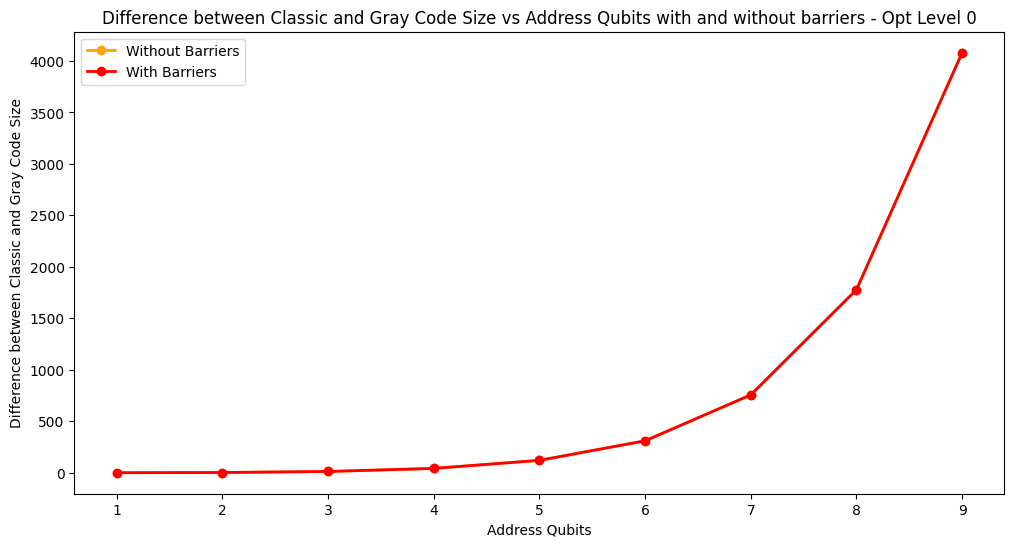

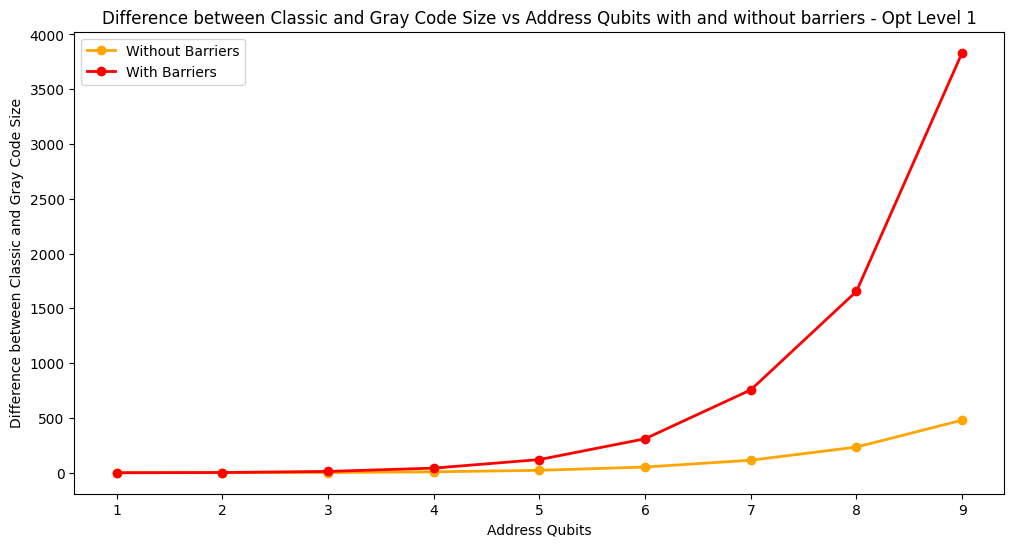

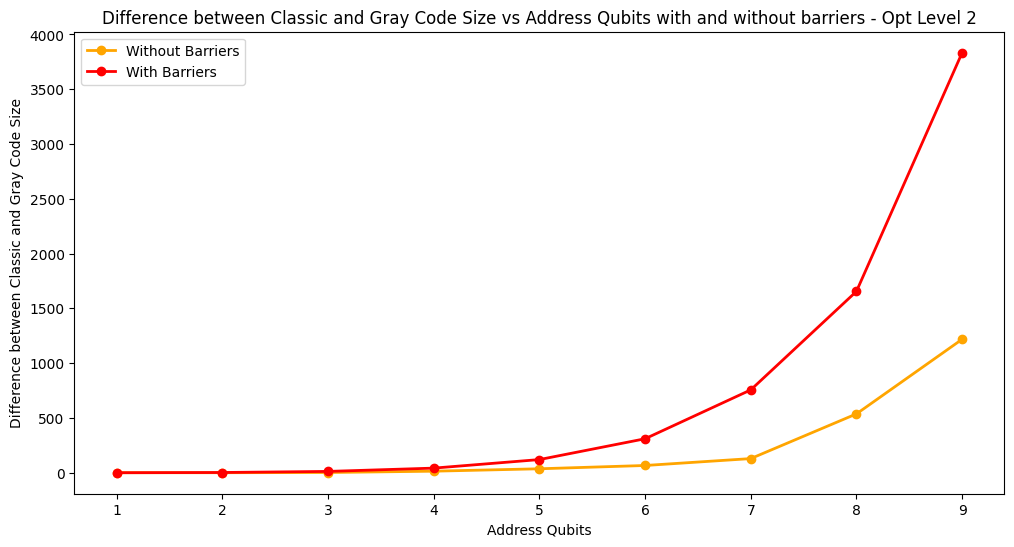

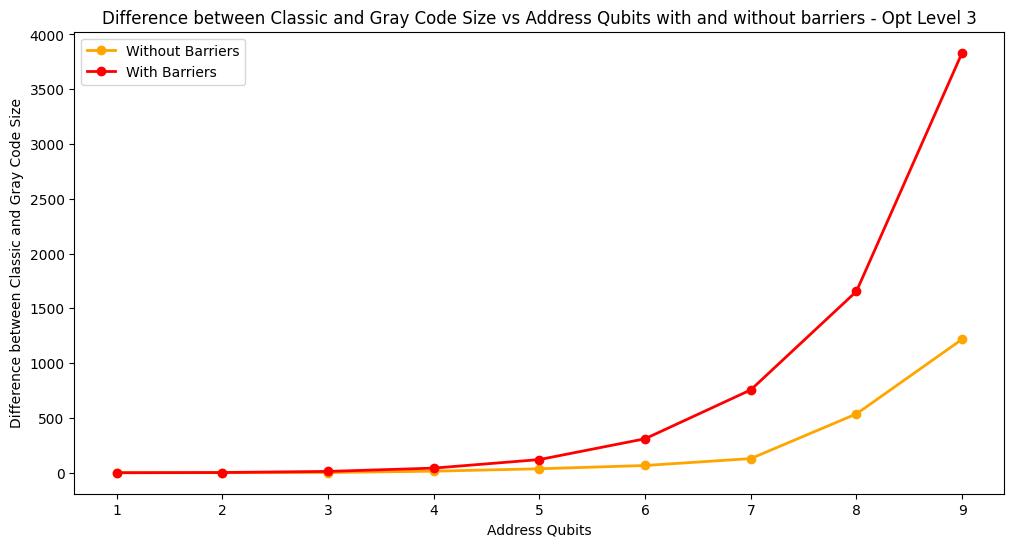

In [4]:

size = range(1,10)

difference_b_size = []
difference_size = []


with open("output.txt", "w") as file:
    for i in range(0, 4):
        file.write(f"Opt Level {i}\n")
        for el in size:
            _, _, _, classic_size, _, _ = ffqram_metrics_classic(el, barrier=False, opt_lvl=i)
            _, _, _, gray_size, _, _ = ffqram_metrics_graycode(el, barrier=False, opt_lvl=i)

            difference_size.append(classic_size - gray_size)

            _, _, _, classic_b_size, _, _ = ffqram_metrics_classic(el, barrier=True, opt_lvl=i)
            _, _, _, gray_b_size, _, _ = ffqram_metrics_graycode(el, barrier=True, opt_lvl=i)

            difference_b_size.append(classic_b_size - gray_b_size)
            file.write(f"Number of address qubits: {el}\n")
            file.write(f"Classic Size: {classic_size}\n")
            file.write(f"Gray Code Size: {gray_size}\n")
            file.write(f"Classic Size with Barriers: {classic_b_size}\n")
            file.write(f"Gray Code Size with Barriers: {gray_b_size}\n")
            file.write(f"Difference between Classic and Gray Code Size: {classic_size - gray_size}\n")
            file.write(f"Difference between Classic and Gray Code Size with Barriers: {classic_b_size - gray_b_size}\n")

        plt.figure(figsize=(12, 6))
        plt.xlabel('Address Qubits')
        plt.ylabel("Difference between Classic and Gray Code Size")
        plt.title(f'Difference between Classic and Gray Code Size vs Address Qubits with and without barriers - Opt Level {i}')
        plt.plot(size, difference_size, marker='o', color='orange', linewidth=2, label='Without Barriers')
        plt.plot(size, difference_b_size, marker='o', color='red', linewidth=2, label='With Barriers')
        plt.legend()
        plt.show()

        difference_size = []
        difference_b_size = []


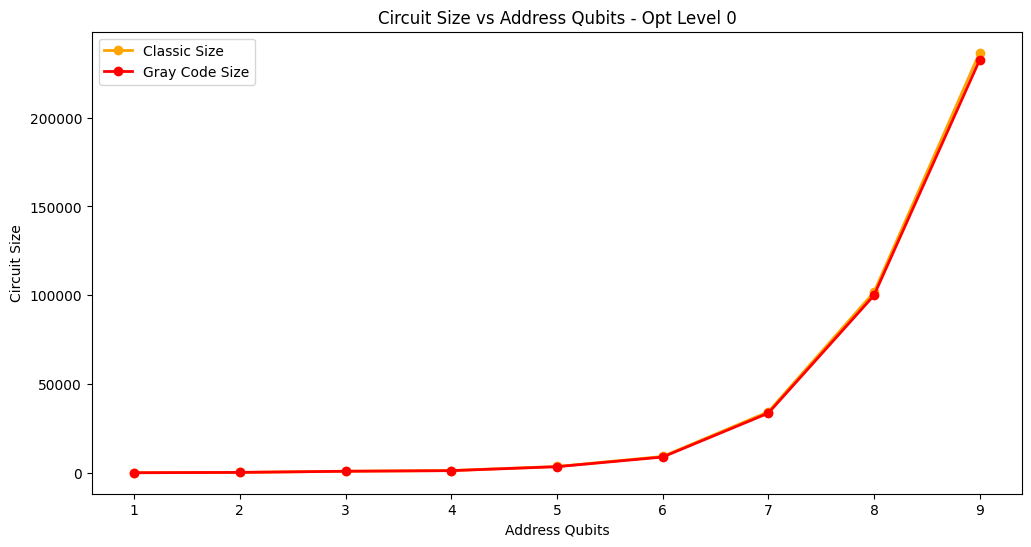

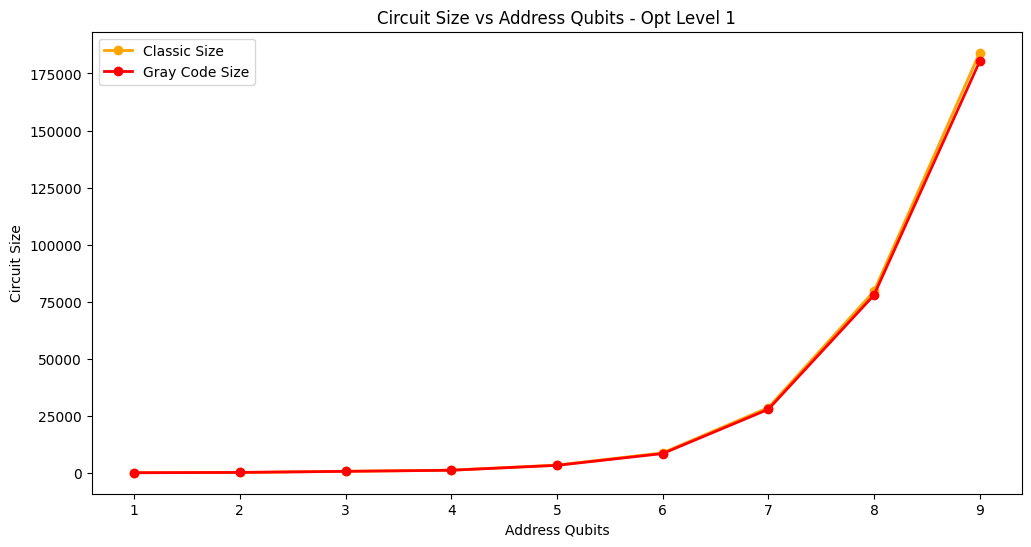

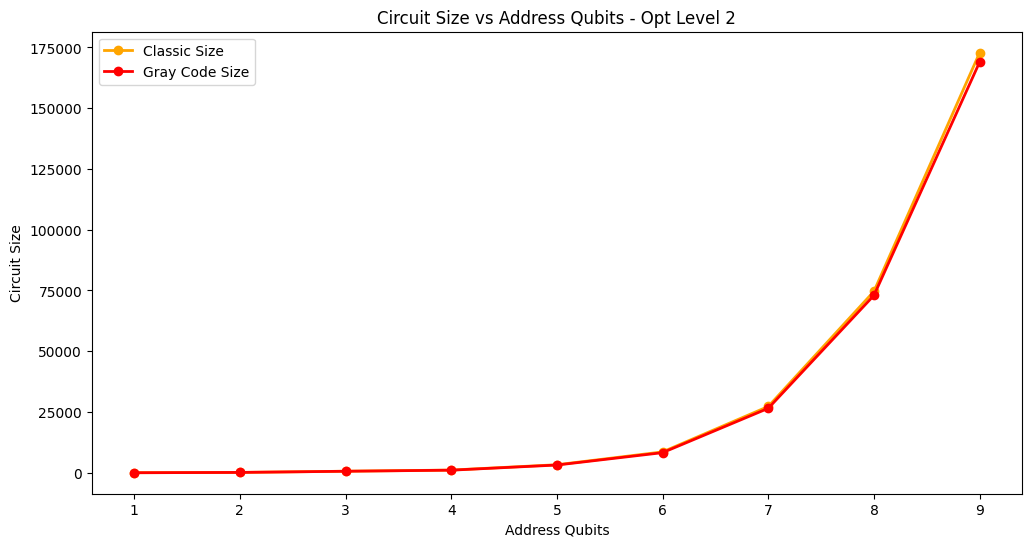

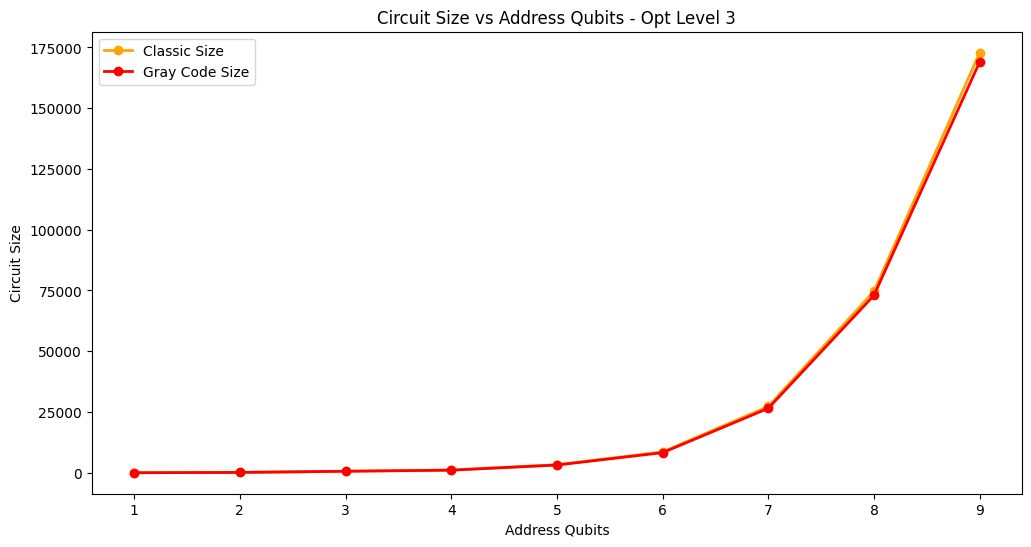

In [5]:
from lib.circuit_metrics import ffqram_metrics_graycode, ffqram_metrics_classic
from matplotlib import pyplot as plt

size = range(1,10)

classic_opt_size = []
gray_opt_size = []


for i in range(0,4):
    for el in size:
        _, _ , _ , classic_size , _ , _ = ffqram_metrics_classic(el, barrier=True, opt_lvl=i)
        _, _ , _ , gray_size , _ , _ = ffqram_metrics_graycode(el, barrier=True, opt_lvl=i)

        classic_opt_size.append(classic_size)
        gray_opt_size.append(gray_size)

    plt.figure(figsize=(12, 6))
    plt.xlabel('Address Qubits')
    plt.ylabel('Circuit Size')
    plt.title(f'Circuit Size vs Address Qubits - Opt Level {i}')
    plt.plot(size, classic_opt_size, marker='o', color='orange', linewidth=2, label='Classic Size')
    plt.plot(size, gray_opt_size, marker='o', color='red', linewidth=2, label='Gray Code Size')
    plt.legend()
    plt.show()
    classic_opt_size = []
    gray_opt_size = []

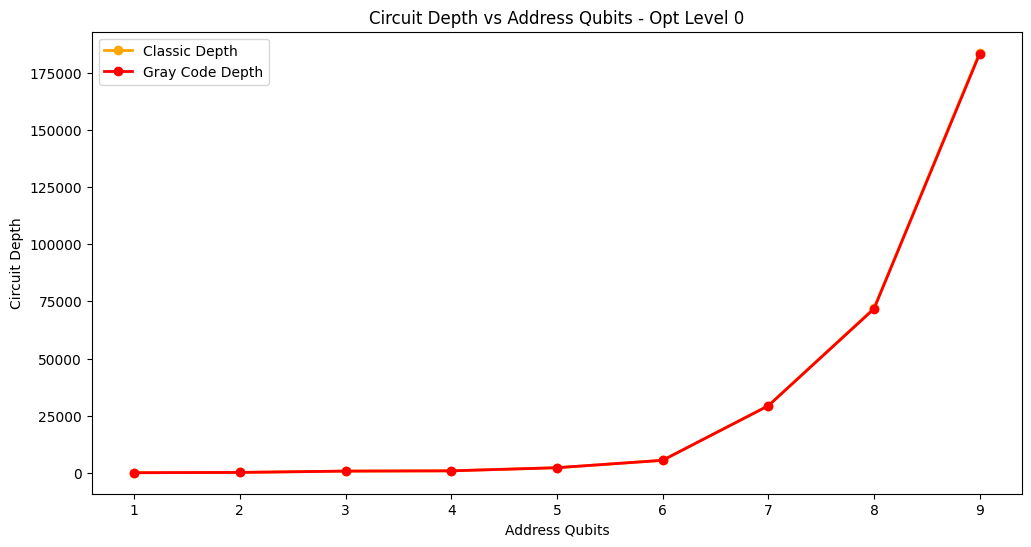

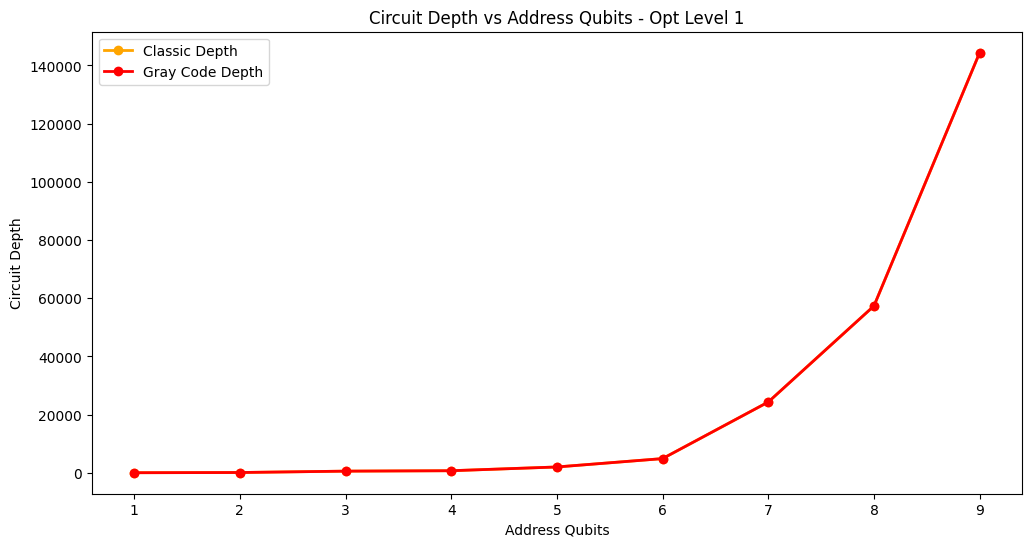

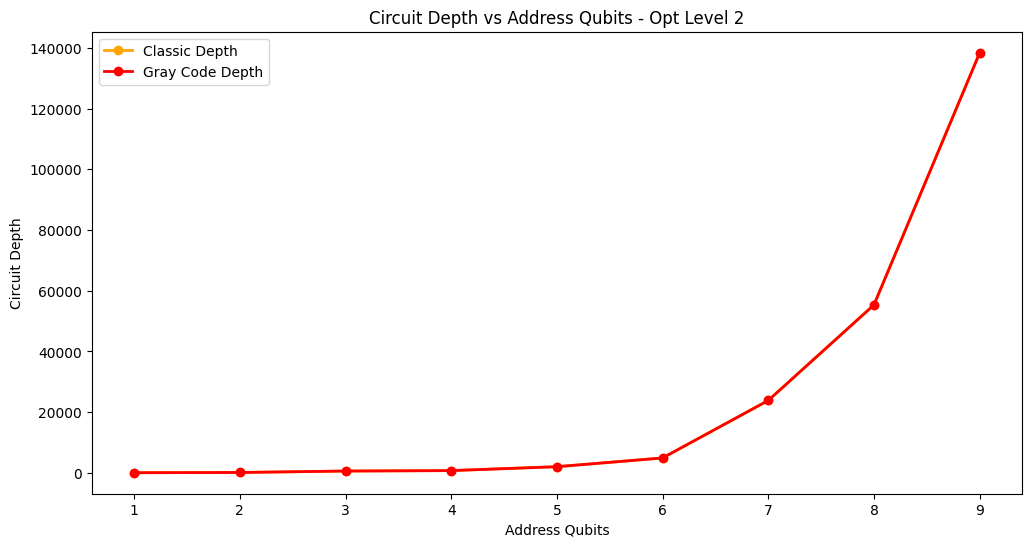

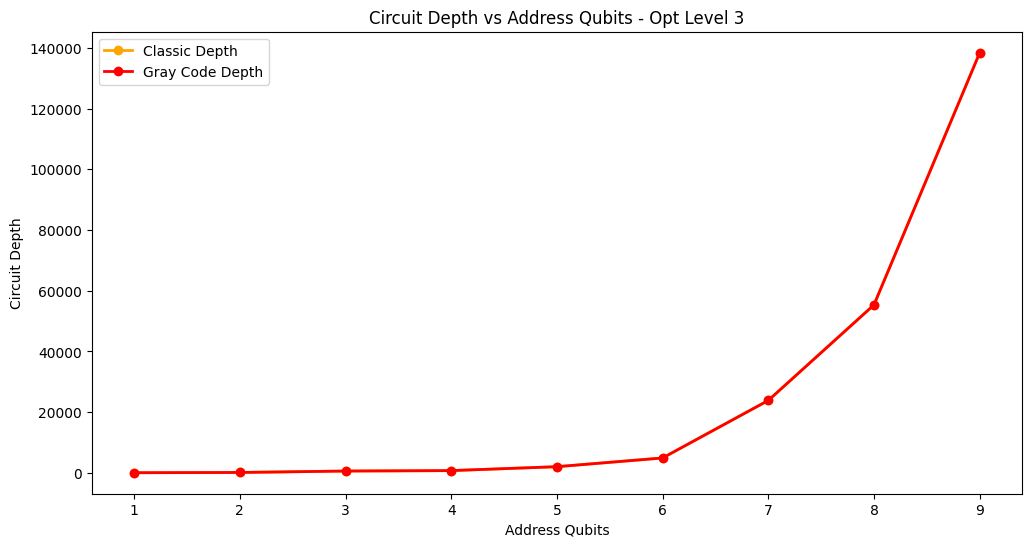

In [1]:
from lib.circuit_metrics import ffqram_metrics_graycode, ffqram_metrics_classic
from matplotlib import pyplot as plt

size = range(1,10)

classic_opt_depth = []
gray_opt_depth = []


for i in range(0,4):
    for el in size:
        _, classic_depth , _ , _ , _ , _ = ffqram_metrics_classic(el, barrier=False, opt_lvl=i)
        _, gray_depth , _ , _ , _ , _ = ffqram_metrics_graycode(el, barrier=False, opt_lvl=i)

        classic_opt_depth.append(classic_depth)
        gray_opt_depth.append(gray_depth)

    plt.figure(figsize=(12, 6))
    plt.xlabel('Address Qubits')
    plt.ylabel('Circuit Depth')
    plt.title(f'Circuit Depth vs Address Qubits - Opt Level {i}')
    plt.plot(size, classic_opt_depth, marker='o', color='orange', linewidth=2, label='Classic Depth')
    plt.plot(size, gray_opt_depth, marker='o', color='red', linewidth=2, label='Gray Code Depth')
    plt.legend()
    plt.show()
    classic_opt_depth = []
    gray_opt_depth = []